#Assignment 2 - CNN over SVHN

In this assignment you are requested to build a convolutional network and train it over the SVHN data, which is a collection of 3X32X32 images, classified into 10 digits. For more information about the dataset, you may go to 
http://ufldl.stanford.edu/housenumbers/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Practical topics in Machine Learning/EX2'

import os
import numpy as np
import torch
from time import time
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

trainset = torchvision.datasets.SVHN(root='./data', split='train',
                                        download=True, transform=transforms.ToTensor())

testset = torchvision.datasets.SVHN(root='./data', split='test',
                                        download=True, transform=transforms.ToTensor())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Practical topics in Machine Learning/EX2
Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [ ]:
len(testset)

26032

In [ ]:
# Use dataloaders for train and test (batch size is 8)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False)

In [ ]:
# The images are tensors of 3, 32, 32
trainset[0][0].shape

torch.Size([3, 32, 32])

Here is what you need to do; you are encoureged to look at notebook "Notebook 11 - CIFAR CNN" when trying to complete the next steps.


Write a network SVHNCnn, that has the following architecture:

* Convolution with 10 3X3 filters
* Relu
* Max pool with 2X2
* Convolution with 5 3X3 filters
* Relu
* Convolution with 16 3X3 filters
* Relu
* Max pool with 2X2
* Convolution with 24 3X3 filters
* Relu
* Max pool with 2X2
* Liner, output size 128
* Relu
* Liner, output size 64
* Relu
* Liner, output size 10

In [ ]:
class SVHNCnn(nn.Module):

    def __init__(self):
        super(SVHNCnn, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.conv2 = nn.Conv2d(10, 5, 3)
        self.conv3 = nn.Conv2d(5, 16, 3)
        self.conv4 = nn.Conv2d(16, 24, 3)

        # Using Batch normalization on the convolution layers
        self.batchNorm2d_0 = nn.BatchNorm2d(10)
        self.batchNorm2d_1 = nn.BatchNorm2d(5)
        self.batchNorm2d_2 = nn.BatchNorm2d(16)
        self.batchNorm2d_3 = nn.BatchNorm2d(24)

        # 3 FC layers
        self.fc1 = nn.Linear(24 * 1 * 1, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.batchNorm2d_0(self.conv1(x))), (2, 2))
        x = F.relu(self.batchNorm2d_1(self.conv2(x)))
        x = F.max_pool2d(F.relu(self.batchNorm2d_2(self.conv3(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.batchNorm2d_3(self.conv4(x))), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

Write a code that trains the network with SVHN train dataset, for classification (use cross entropy, and SGD).
Run the network for at least 10 epochs, over the entire dataset. Make sure to print the loss over the train set as well as the **test set** over time (say, every 1000 batches, but it's up to you), so you will know where you are during training. 

Note, measuring loss of test is similar to measuring loss over the train test. However, make sure not to run the test images in back propagation. Use them only in forward and calulate the average loss over the entire test set. Since it will make the training process run slower, you should measure loss for the test set only at the end of an epoch (so overall you get 10 loss values for the test set). You are encoureged to write a different function for claculating the loss of the test set, and then call it from the training procedure.


You should collect the loss values in an array, so you can plot then into two curves, one for train and one for test.

In addition, you should measure the time it takes you to train the network completely.



In [ ]:
def train(model, trainloader, testloader, criterion, optimizer, lr):
    
    train_losses, test_losses = [], []
    
    EPOCHS = 10

    # Count wall-clock time for the whole training process
    start_time = time()

    for epoch in range(EPOCHS):

        # Training mode
        model.train()

        sum_loss = 0.0
        running_loss = 0.0

        for batch_idx, (inputs, labels) in enumerate(trainloader):

            # Zero the gradients from the previous iteration
            optimizer.zero_grad()

            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass
            outputs = model(inputs)

            # Compute Cross entropy loss
            loss = criterion(outputs, labels)
            sum_loss += loss.item()
            running_loss += loss.item()

            # Back propagation- computing the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            if (batch_idx + 1) % 1000 == 0:
                current = running_loss / 1000
                train_losses.append(current)
                print("Epoch: {}/{}...".format(epoch + 1, EPOCHS),
                      "Step: {}...".format(batch_idx + 1),
                      "Train Loss: {:.3f}...".format(current))
                running_loss = 0.0

        # Compute the loss on the training set in the current epoch
        train_loss = sum_loss / len(trainloader.dataset)

        # Compute the loss on the test set in the current epoch
        test_loss = calculate_test_loss(model, testloader, criterion)
        test_losses.append(test_loss)

        print("Epoch: {}/{}...".format(epoch + 1, EPOCHS),
              "Train Loss: {:.3f}...".format(train_loss),
              "Test Loss: {:.3f}".format(test_loss))

        # Decay the learning rate every three epochs
        if (epoch + 1) % 3 == 0:
            lr /= 2
            for group in optimizer.param_groups:
                group['lr'] = lr
                print("It's epoch number {} and the new lr is {}".format(epoch + 1, group['lr']))

    passed_time = time() - start_time
    print('The training ended after %.3f minutes' % (passed_time / 60))

    return epochs_train_loss, epochs_test_loss


In [ ]:
def calculate_test_loss(model, data_loader, criterion):
    
    # Evaluation mode
    model.eval()

    sum_loss = 0.0

    with torch.no_grad():
        
        for batch_idx, (inputs, labels) in enumerate(data_loader):
           
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass
            outputs = model(inputs)

            # Compute Cross entropy loss
            loss = criterion(outputs, labels)
            sum_loss += loss.item()

    # Return the loss on the test set
    return sum_loss / len(data_loader.dataset)

In [ ]:
def plot_graph(dataset, loss, folder):
    plt.title("Loss Over " + dataset)

    label, color, ticks = (
    "Number of batches seen / 1000", 'blue', [i for i in range(0, 90 + 1, 9)]
    ) if dataset == 'Train' else ("Epochs", 'red', range(len(loss)))

    plt.plot(range(len(loss)), loss, label=dataset + ' Loss', color=color)

    plt.ylabel("Loss")
    plt.xlabel(label)

    plt.xticks(ticks)
    plt.legend(frameon=False)
    plt.savefig(folder + '/' + "Loss over " + dataset + ".png", dpi=192)
    plt.show()

In [ ]:
def plot(folder_name, loss_train, loss_test):
    
    # Create a dir in the current working directory in which the generated
    # graphs will be saved
    output_dir = folder_name + "_ results"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print("\t---------Results with " + folder_name + "---------\n")

    # Plotting the graphs for both training set and test set
    plot_graph("Train", loss_train, output_dir)
    plot_graph("Test", loss_test, output_dir)

Write a function that evaluates the resulted model over the entire test data of SVHN. Provide a single accuracy number.

In [ ]:
# Your code goes here
def calculate_accuracy(model, data_loader):
    
    correct = 0
    total = 0

    with torch.no_grad():

        for batch_idx, (inputs, labels) in enumerate(data_loader):

            if torch.cuda.is_available():
                inputs = inputs.cuda()

            # Forward pass
            outputs = model(inputs)
            outputs = outputs.detach().cpu()

            predictions = np.argmax(outputs.data, axis=1)

            total += labels.size(0)
            correct += (predictions == labels).sum().item()

    return 100 * correct / total

# Training with a CPU 


In [ ]:
model_cpu = SVHNCnn()

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define the learning rate
lr=0.004

# Define the optimizer
optimizer = torch.optim.SGD(model_cpu.parameters(), lr=lr,momentum=0.9)

In [ ]:
# Training with CPU
cpu_train_loss, cpu_test_loss= train(model_cpu, trainloader, testloader,criterion, optimizer,lr)

Epoch: 1/10... Step: 1000... Train Loss: 1.740...
Epoch: 1/10... Step: 2000... Train Loss: 1.034...
Epoch: 1/10... Step: 3000... Train Loss: 0.861...
Epoch: 1/10... Step: 4000... Train Loss: 0.809...
Epoch: 1/10... Step: 5000... Train Loss: 0.762...
Epoch: 1/10... Step: 6000... Train Loss: 0.725...
Epoch: 1/10... Step: 7000... Train Loss: 0.696...
Epoch: 1/10... Step: 8000... Train Loss: 0.672...
Epoch: 1/10... Step: 9000... Train Loss: 0.668...
Epoch: 1/10... Train Loss: 0.110... Test Loss: 0.091
Epoch: 2/10... Step: 1000... Train Loss: 0.623...
Epoch: 2/10... Step: 2000... Train Loss: 0.643...
Epoch: 2/10... Step: 3000... Train Loss: 0.591...
Epoch: 2/10... Step: 4000... Train Loss: 0.632...
Epoch: 2/10... Step: 5000... Train Loss: 0.616...
Epoch: 2/10... Step: 6000... Train Loss: 0.606...
Epoch: 2/10... Step: 7000... Train Loss: 0.606...
Epoch: 2/10... Step: 8000... Train Loss: 0.599...
Epoch: 2/10... Step: 9000... Train Loss: 0.596...
Epoch: 2/10... Train Loss: 0.077... Test Loss: 

	---------Results with CPU---------



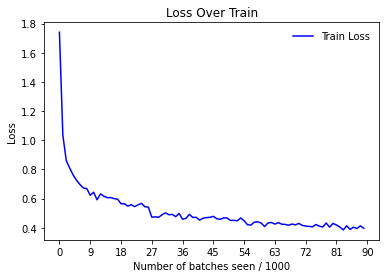

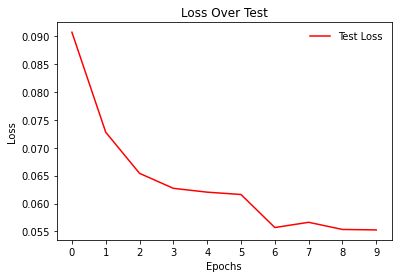

In [ ]:
# Plot the loss graphs
plot("CPU",cpu_train_loss, cpu_test_loss)

In [ ]:
# Calculate the accuracies
print('Accuracy on the training set: %d%%\nAccuracy on the test set: %d%%' 
      % (calculate_accuracy(model_cpu,trainloader),calculate_accuracy(model_cpu,testloader)))

Accuracy on the training set: 89%
Accuracy on the test set: 86%


# Training with a GPU 
You are requested to change your code to use the GPU instead of the CPU.
This can be easily done bu converting every torch.tensor to torch.cuda.tensor. 

Specific instructions:
* Change the hardware equipent of your colab notebook. To do that, go to the "Runtime" menu, and then to "Change runtime type". In the dialog box, change "Hardware accelerator" to GPU.
* Please follow the lines that were commented out with the comment    # -- For GPU (in notebook 11)
* Also, remove the lines that have the comment # -- For CPU

Train your network again and compare training time.

In [ ]:
model_GPU = SVHNCnn().cuda()

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define the learning rate
lr=0.004

# Define the optimizer
optimizer = torch.optim.SGD(model_GPU.parameters(), lr=lr,momentum=0.9)

In [ ]:
# Training with GPU
gpu_train_loss, gpu_test_loss= train(model_GPU, trainloader, testloader,criterion, optimizer,lr)

Epoch: 1/10... Step: 1000... Train Loss: 1.841...
Epoch: 1/10... Step: 2000... Train Loss: 1.060...
Epoch: 1/10... Step: 3000... Train Loss: 0.874...
Epoch: 1/10... Step: 4000... Train Loss: 0.785...
Epoch: 1/10... Step: 5000... Train Loss: 0.722...
Epoch: 1/10... Step: 6000... Train Loss: 0.682...
Epoch: 1/10... Step: 7000... Train Loss: 0.692...
Epoch: 1/10... Step: 8000... Train Loss: 0.646...
Epoch: 1/10... Step: 9000... Train Loss: 0.658...
Epoch: 1/10... Train Loss: 0.110... Test Loss: 0.076
Epoch: 2/10... Step: 1000... Train Loss: 0.604...
Epoch: 2/10... Step: 2000... Train Loss: 0.609...
Epoch: 2/10... Step: 3000... Train Loss: 0.607...
Epoch: 2/10... Step: 4000... Train Loss: 0.598...
Epoch: 2/10... Step: 5000... Train Loss: 0.582...
Epoch: 2/10... Step: 6000... Train Loss: 0.561...
Epoch: 2/10... Step: 7000... Train Loss: 0.550...
Epoch: 2/10... Step: 8000... Train Loss: 0.584...
Epoch: 2/10... Step: 9000... Train Loss: 0.567...
Epoch: 2/10... Train Loss: 0.073... Test Loss: 

	---------Results with GPU---------



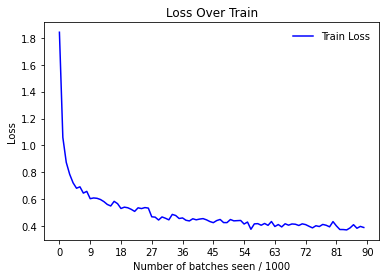

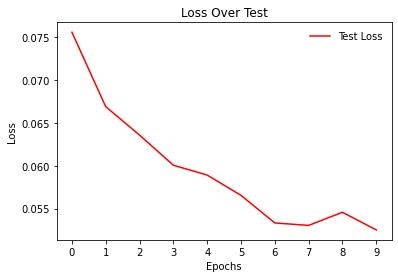

In [ ]:
# Plot the loss graphs
plot("GPU",gpu_train_loss, gpu_test_loss)

In [ ]:
# Calculate the accuracies
print('Accuracy on the training set: %d%%\nAccuracy on the test set: %d%%' 
      % (calculate_accuracy(model_GPU,trainloader),calculate_accuracy(model_GPU,testloader)))

Accuracy on the training set: 89%
Accuracy on the test set: 87%


# Submission instructions

You should submit a pdf file with the following items:

CPU Experiment:
*   Plot of loss curves (train in blue, test in red)
*   Training time

GPU Experiment:
*   Plot of loss curves (train in blue, test in red)
*   Training time

Link for your collab notebook.
ID and names of submitters.


Good luck!